<a href="https://colab.research.google.com/github/Chaitanyapp12/Data-Science/blob/main/Heart_Disease_Risk_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.75      0.62       114
           1       0.31      0.15      0.20        86

    accuracy                           0.49       200
   macro avg       0.42      0.45      0.41       200
weighted avg       0.44      0.49      0.44       200



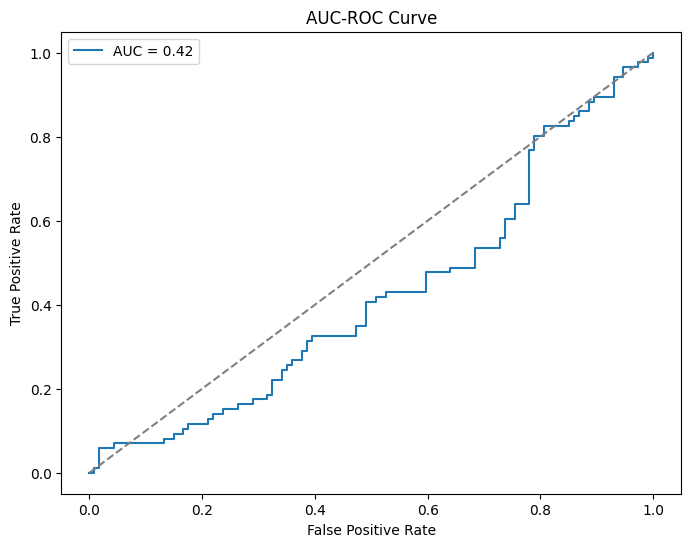

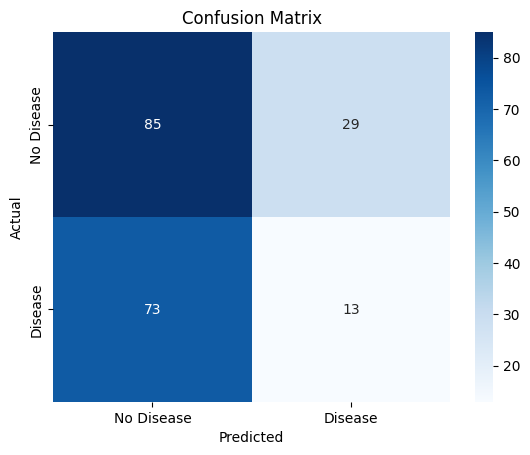

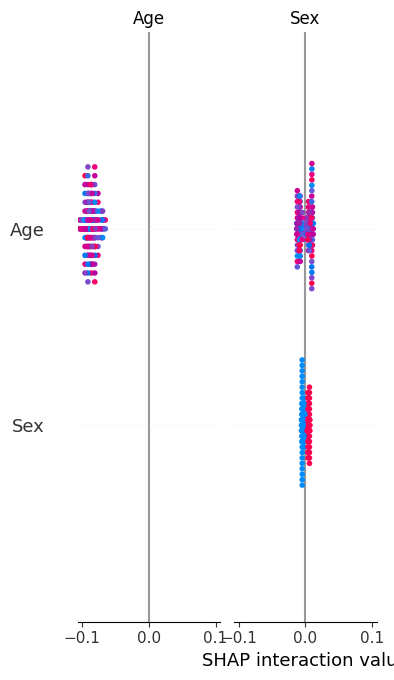

Model saved as heart_disease_advanced_model.pkl

UI code saved as heart_disease_ui.py


In [6]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import shap
import joblib

# Step 2: Generate Synthetic Dataset
np.random.seed(42)
n_samples = 1000

data = pd.DataFrame({
    'Age': np.random.randint(29, 77, n_samples),
    'Sex': np.random.choice([0, 1], size=n_samples),  # 0 = Female, 1 = Male
    'ChestPainType': np.random.choice([0, 1, 2, 3], size=n_samples),  # Encoded types
    'RestingBP': np.random.randint(80, 200, n_samples),
    'Cholesterol': np.random.randint(120, 400, n_samples),
    'FastingBS': np.random.choice([0, 1], size=n_samples),  # Fasting Blood Sugar
    'RestingECG': np.random.choice([0, 1, 2], size=n_samples),  # Encoded ECG results
    'MaxHR': np.random.randint(60, 202, n_samples),
    'ExerciseAngina': np.random.choice([0, 1], size=n_samples),  # 0 = No, 1 = Yes
    'Oldpeak': np.random.uniform(0, 6, n_samples),
    'ST_Slope': np.random.choice([0, 1, 2], size=n_samples),  # Encoded slope values
    'HeartDisease': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4])  # Target variable
})

# Step 3: Preprocessing
X = data.drop(['HeartDisease'], axis=1)
y = data['HeartDisease']

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Step 5: Model Evaluation
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC Curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 6: Explainability with SHAP

# Ensure you use the unscaled version of the dataset for SHAP
X_unscaled_test = pd.DataFrame(scaler.inverse_transform(X_test), columns=data.columns[:-1])

# Create the SHAP explainer for RandomForest
explainer = shap.Explainer(best_model, X_train)

# Compute SHAP values
shap_values = explainer(X_unscaled_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_unscaled_test, feature_names=data.columns[:-1])


# Step 7: Save the Model
joblib.dump(best_model, 'heart_disease_advanced_model.pkl')
print("Model saved as heart_disease_advanced_model.pkl")

# Step 8: Streamlit UI Code
ui_code = '''
import streamlit as st
import numpy as np
import joblib

# Load the trained model
model = joblib.load('heart_disease_advanced_model.pkl')

st.title("Advanced Heart Disease Risk Assessment")

# User input fields
age = st.number_input("Age", min_value=29, max_value=77, step=1)
sex = st.selectbox("Sex", [0, 1], format_func=lambda x: "Female" if x == 0 else "Male")
chest_pain = st.selectbox("Chest Pain Type", [0, 1, 2, 3])
resting_bp = st.slider("Resting Blood Pressure", min_value=80, max_value=200, step=1)
cholesterol = st.slider("Cholesterol", min_value=120, max_value=400, step=1)
fasting_bs = st.selectbox("Fasting Blood Sugar > 120 mg/dL", [0, 1])
resting_ecg = st.selectbox("Resting ECG Results", [0, 1, 2])
max_hr = st.slider("Maximum Heart Rate", min_value=60, max_value=202, step=1)
exercise_angina = st.selectbox("Exercise Induced Angina", [0, 1])
oldpeak = st.slider("ST Depression (Oldpeak)", min_value=0.0, max_value=6.0, step=0.1)
st_slope = st.selectbox("Slope of the Peak Exercise ST Segment", [0, 1, 2])

# Predict button
if st.button("Predict"):
    input_data = np.array([[age, sex, chest_pain, resting_bp, cholesterol, fasting_bs,
                            resting_ecg, max_hr, exercise_angina, oldpeak, st_slope]])
    prediction = model.predict(input_data)
    risk_proba = model.predict_proba(input_data)[0][1]

    if prediction[0] == 1:
        st.error(f"High Risk of Heart Disease! Risk Score: {risk_proba:.2f}")
    else:
        st.success(f"Low Risk of Heart Disease. Risk Score: {risk_proba:.2f}")
'''

# Save the Streamlit UI code to a file
with open('heart_disease_ui.py', 'w') as f:
    f.write(ui_code)

print("\nUI code saved as heart_disease_ui.py")
